In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from statistics import fmean

In [97]:
df_data = pd.read_csv("data.csv").dropna(axis=1, how='all')
df_data.drop(columns=['id', 'fractal_dimension_worst'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df_data.drop(columns=['diagnosis'])
    , df_data['diagnosis']
    , test_size=0.2
    , random_state=0
    , stratify=df_data['diagnosis']
)
# after getting a convergence warning for LR during CV, i chose to scale the data:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

Let's first take a look at our predictors after excluding the response variable from the dataframe:

In [90]:
df_data.drop(columns=['diagnosis']).shape

(569, 29)

We see that our data set has 29 predictors...

In [91]:
len(y_train)

455

... and our training set contains 455 observations.

In order to know how good of a fit discriminant analysis is in our case, we first need to check whether our predictors come from a multivariate normal distribution or not. If not, then we could still run LDA or QDA for the sake of comparison, but it is unlikely to yield good results. We will run the Henze-Zirkler test with a method from the ```pingouin``` library:

In [98]:
pg.multivariate_normality(X_train, alpha=.05)

HZResults(hz=np.float64(1.1875820156905261), pval=np.float64(0.0), normal=False)

In the Henze-Zirkler test the null hypothesis is that the data follows a multivariate normal distribution, so here with a p-value of ```0.0``` we can safely reject that null hypothesis and conclude that our data failed the multivariate normality check, so we should better forget about discriminant analysis for now and explore alternative models.

Since discriminant analysis is not an option here, we will turn to logistic regression instead. Also, since our interest is in comparing low variance and low bias methods, we will fit k-NN, k=3 and k-NN, k=15 to our data set as well and compare the results to logistic regression.

In [99]:
outcome_counts = y_train.value_counts()
outcome_counts

diagnosis
B    285
M    170
Name: count, dtype: int64

In [94]:
print("Malign outcome %% : %s%%" % (100 * round(outcome_counts['M']/outcome_counts.sum(axis=0), 3)))

Malign outcome % : 37.4%


As we can see from the result printed above, our data set is moderately imbalanced: ```M```(malign) outcomes make up only 37% of the data, and so benign makes up 63%. For that reason we'll use ```StratifiedKFold``` instead of the basic KFold object, although the imbalance here is really moderate so using KFold would surely not yield results that are much worse.

In [82]:
def predictLogit(train_X, train_y, test_X):
    model = LogisticRegression().fit(train_X, train_y)
    y_hat = model.predict(test_X)
    return y_hat


def predictKNN(train_X, train_y, test_X, k):
    model = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    y_hat = model.predict(test_X)
    return y_hat

In [100]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

accuracies_logit, accuracies_3NN, accuracies_15NN = [], [], []

for train_ix, val_ix in skf.split(X_train, y_train):

    fold_x_train, fold_x_val = X_train.iloc[train_ix], X_train.iloc[val_ix]
    fold_y_train, fold_y_val = y_train.iloc[train_ix], y_train.iloc[val_ix]

    y_hat_logit = predictLogit(fold_x_train, fold_y_train, fold_x_val)
    y_hat_3NN = predictKNN(fold_x_train, fold_y_train, fold_x_val, 3)
    y_hat_15NN = predictKNN(fold_x_train, fold_y_train, fold_x_val, 15)

    accuracies_logit.append(accuracy_score(y_true=fold_y_val, y_pred=y_hat_logit))
    accuracies_3NN.append(accuracy_score(y_true=fold_y_val, y_pred=y_hat_3NN))
    accuracies_15NN.append(accuracy_score(y_true=fold_y_val, y_pred=y_hat_15NN))

accuracies = [accuracies_logit, accuracies_3NN, accuracies_15NN]
avg_accuracies = list(map(fmean, accuracies))
avg_accuracies = [round(m, 4) for m in avg_accuracies]

df_acc = pd.DataFrame({'avg accuracy': avg_accuracies})
df_acc.index = pd.Index(['logit', 'k-NN, k=3', 'k-NN, k=15'])
df_acc

,avg accuracy
logit,0.9846
"k-NN, k=3",0.9647
"k-NN, k=15",0.9604


Scaling the data had a noticeable positive impact on our accuracy measurements, as we can see by comparing the new results above to the screenshot below that contains the previous results before scaling our data.

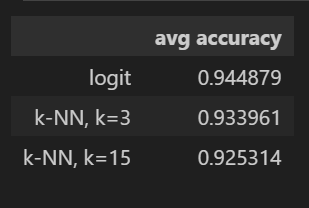

Since LR clearly had the highest accuracy over the 10 folds, we select this model to perform a prediction test on our reserved unseen data (```X_test```):

In [101]:
y_hat = predictLogit(X_train, y_train, X_test)

In [106]:
cf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat)
accuracy = round((cf_mat[0,0] + cf_mat[1,1]) / len(y_test), 4)
sensitivity = round(cf_mat[1,1] / (cf_mat[1,1] + cf_mat[1,0]), 4)
specificity = round(cf_mat[0,0] / (cf_mat[0,0] + cf_mat[0,1]), 4)

df_report = pd.DataFrame({'Score': [accuracy, sensitivity, specificity]})
df_report.index = pd.Index(['accuracy', 'sensitivity', 'specificity'])
df_report

,Score
accuracy,0.9649
sensitivity,0.9524
specificity,0.9722


We notice that the accuracy of LR here is slightly lower than the average accuracy obtained from cross validation, which is perfectly normal (since the performance measurements from the folds are correlated). The accuracy obtained on the test set is only 2% lower than that from cross validation, so we conclude that logistic regression generalises pretty well in this case. The two other performance measures are also excellent, particularly specificity which means LR classifies negatives very well here.